### Compute IV-O2SLS

### TODO

- try different noises rand and randn -> understand what happens when you put everywhere rand and ground truth is worse that 2SLS and OLS
- try to implement the same but for bandits 
- why on cumulative regret when I plot it for the ground truth I dont see a straight line through zero? check that and check if the cumulative regret plots are sound.
- think if you can improve the the self-fulfilling bias term analysis by using Jensen and making the summation inside sqrt and trying to find a covariance between epsilon and eta
- find range of parameters where 2SLS is clearly better than OLS 

In [1]:
import numpy as np
from scipy.stats import t as t_law
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
# folder = "xps/RidgeForwardComparison/"

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [17]:
## PARAMETERS 
n_iters = 100
T = 200
sigma =1.
# index_reg=3
d, lamda = 20, .1 #lamdas[index_reg]  # coordinate dimension, regularization
methods = ['Ridge','2SLS','Oracle']  # 'Oracle' is using the true parameter
online_loss = np.zeros((n_iters, len(methods), T))
# fst_terms = np.zeros((n_iters, len(methods), T))
# scd_terms = np.zeros((n_iters, len(methods), T))

theta_star = np.random.randn(d,d)
# theta_star = np.eye(d,d)
beta_star = np.random.multivariate_normal([10],[[1]],d).reshape(-1,)
print("beta = ", beta_star, "\ntheta = ", theta_star)

beta =  [10.23455829 10.17976983 10.17704777  9.96609844 10.08314598  8.77352917
 11.04202281  8.61649528  8.94530826  8.90828868  9.55505116  8.74757433
  9.84383922  9.586575   11.1222004  10.51215917  9.24213412  9.97791469
  8.34490176  9.98305621] 
theta =  [[ 1.12401467e-01 -6.97897400e-01 -1.28205488e+00  4.58555520e-01
  -9.50947834e-01  1.16085325e+00  1.15383570e+00 -7.48243694e-03
  -5.00208595e-01  1.13845980e+00  1.57115966e-01  1.17476674e+00
  -7.11023903e-01  1.26557246e+00 -5.90826832e-02 -1.00099382e+00
   3.11080653e-01  3.47819758e-02 -6.92239028e-01 -6.39223535e-01]
 [-6.49920695e-01  1.91741793e+00 -7.37923884e-02  8.52500429e-01
   3.71734989e-01 -6.63069213e-01  2.97207734e-01  3.41943917e-01
   9.88565686e-01  1.33971918e-03  5.20665584e-01 -8.29869203e-01
   6.03999065e-01  6.34650136e-01  5.75105525e-01 -4.04120856e-01
  -2.61494832e-01  4.01207458e-01  1.46912618e+00 -2.25574156e+00]
 [ 1.22885677e+00  2.82111782e-01  2.29291464e-02  2.83817841e-01
  -1.4518

In [21]:
store_betas = np.zeros((len(methods), n_iters, d))

# Run
for it in range(n_iters):  # iterations to average the effect of noise
    
    # INITIALIZE
    thetas = np.zeros((len(methods),d,d))
    thetas[-1] = theta_star
    betas = np.zeros((len(methods),d))
    betas[-1] = beta_star
    GXXinv = np.eye(d)/lamda
    GZXinv = np.eye(d)/lamda
    # GZXinv = np.zeros((d,d))
    GZX = np.zeros((d,d))
    GXX = np.zeros((d,d))

    ## MODEL 
    # first stage
    Z = np.random.randn(T,d)
    eps = np.random.randn(T, d)
    # eps = np.zeros((T,d))
    X = np.dot(Z, theta_star) + eps
    # second stage
    eta_tilde = sigma*np.random.randn(T)
    # eta = eta_tilde + np.linalg.norm(eps, axis=1)  
    eta = eta_tilde + eps[:,0] + eps[:,1] + eps[:,2]
    y = np.dot(X, beta_star) + eta

    # some bounds
    L_Z, L_X, L_y = max(np.linalg.norm(Z, axis=1)), max(np.linalg.norm(X, axis=1)), max(abs(y))  # signal level

    # start online regression for T rounds
    for t in range(T):
        z_t, x_t, y_t = Z[t], X[t], y[t]
        # update online losses
        online_loss[it, :, t] = (np.dot(betas, x_t) - y_t)**2

        ## RIDGE REGRESSION 
        update_beta_ridge = np.dot(GXXinv, np.dot(np.outer(x_t, x_t), betas[0]) - y_t*x_t) # G_{XX,t}^{-1} x_t x_t^T beta - y_t x_t
        if t<T-1:
            GXX += np.outer(x_t, x_t)
            _XGinvX = np.inner(X[t+1], np.dot(GXXinv, X[t+1]))  # x_{t+1}^T G_{XX,t}^{-1} x_{t+1}
            new_GXXinv = GXXinv - np.dot(GXXinv, np.dot(np.outer(X[t+1], X[t+1]), GXXinv))/(1+_XGinvX)  
        betas[0] -= update_beta_ridge  
        GXXinv = new_GXXinv

        ### IV-O2SLS
        # update_beta_O2SLS = np.dot(GZXinv, np.dot(np.outer(z_t, x_t), betas[1]) - y_t*z_t)
        # if t<T-1:
        #     GZX += np.outer(z_t, x_t)
        #     _XGinvZ = np.inner(X[t+1], np.dot(GZXinv, Z[t+1]))  # z_{t+1}^T G_{XX,t}^{-1} x_{t+1}
        #     new_GZXinv = GZXinv - np.dot(GZXinv, np.dot(np.outer(X[t+1], Z[t+1]), GZXinv))/(1+_XGinvZ) 
        # betas[1] -= update_beta_O2SLS
        # GZXinv = new_GZXinv

        ### IV-O2SLS
        # update_beta_O2SLS = np.dot(GZXinv, np.dot(np.outer(z_t, x_t), betas[1]) - y_t*z_t)
        # if t == 0:
        #     new_GZXinv = np.linalg.inv(np.outer(z_t, x_t) + np.eye(d)*1e-10)
        #     # GZX += np.outer(z_t, x_t)
        # if 0<t<T-1:
        #     # GZX += np.outer(z_t, x_t)
        #     _XGinvZ = np.inner(X[t+1],np.dot(GZXinv, Z[t+1]))  # z_{t+1}^T G_{XX,t}^{-1} x_{t+1}
        #     new_GZXinv = GZXinv - np.dot(GZXinv, np.dot(np.outer(X[t+1], Z[t+1]), GZXinv))/(1+_XGinvZ) 
        # betas[1] -= update_beta_O2SLS
        # GZXinv = new_GZXinv

        ### IV-O2SLS
        # update_beta_O2SLS = np.dot(GZXinv, np.dot(np.outer(z_t, x_t), betas[1]) - y_t*z_t) # first piece is small second is big
        # lim = 999
        # if t < lim:
        #    GZX += np.outer(z_t, x_t)
        # if t == lim:
        #     GZXinv = np.linalg.inv(GZX + np.outer(z_t, x_t))
        # if lim<t<T-1:
        #     _XGinvZ = np.inner(X[t+1],np.dot(GZXinv, Z[t+1]))  # z_{t+1}^T G_{XX,t}^{-1} x_{t+1}
        #     new_GZXinv = GZXinv - np.dot(GZXinv, np.dot(np.outer(X[t+1], Z[t+1]), GZXinv))/(1+_XGinvZ) 
        #     GZXinv = new_GZXinv
        # betas[1] -= update_beta_O2SLS

        ## IV-O2SLS expensive computation
        _Z, _X, _y = Z[:t+1,:], X[:t+1,:], y[:t+1]
        betas[1] = np.linalg.inv(_Z.T @ _X + 1e-4*np.eye(d)) @ _Z.T @ _y


    store_betas[0, it, :] = betas[0]
    store_betas[1, it, :] = betas[1]
    store_betas[2, it, :] = betas[2]

In [22]:
# Here I make comparisons with mean values for different iterations and final estimates of beta

mean_beta_ridge = store_betas[0, :, :].mean(axis=0)
std_beta_ridge = store_betas[0, :, :].std(axis=0)
mean_beta_2SLS = store_betas[1, :, :].mean(axis=0)
std_beta_2SLS = store_betas[1, :, :].std(axis=0)
mean_beta_star = store_betas[2, :, :].mean(axis=0)
std_beta_star = store_betas[2, :, :].std(axis=0)

print("||beta - mean_s|| = ", round(np.linalg.norm(beta_star-mean_beta_star),4), "\tbeta = ", beta_star, "\t\tstd=", std_beta_star)
print("||beta - mean_r|| = ", round(np.linalg.norm(beta_star-mean_beta_ridge),4),  "\tbeta_r = ", betas[0], "\tstd=", std_beta_ridge)
print("||beta - mean_IV|| = ", round(np.linalg.norm(beta_star-mean_beta_2SLS),4), "\tbeta_IV = ", betas[1], "\tstd=", std_beta_2SLS)
print("L_Z is: ", round(L_Z,4))
print("L_X is: ", round(L_X,4))
print("L_y is: ",round(L_y,4))
print("max |eta_t| is: ", max(abs(eta)))
print(methods)
print(np.sqrt(((betas-beta_star)**2).sum(axis=1)))

||beta - mean_s|| =  0.0 	beta =  [10.23455829 10.17976983 10.17704777  9.96609844 10.08314598  8.77352917
 11.04202281  8.61649528  8.94530826  8.90828868  9.55505116  8.74757433
  9.84383922  9.586575   11.1222004  10.51215917  9.24213412  9.97791469
  8.34490176  9.98305621] 		std= [1.77635684e-14 0.00000000e+00 0.00000000e+00 1.77635684e-14
 1.24344979e-14 1.77635684e-14 5.32907052e-15 1.24344979e-14
 8.88178420e-15 1.59872116e-14 1.42108547e-14 1.95399252e-14
 1.24344979e-14 1.95399252e-14 3.01980663e-14 1.95399252e-14
 1.06581410e-14 1.24344979e-14 3.55271368e-15 1.06581410e-14]
||beta - mean_r|| =  0.5608 	beta_r =  [10.45691543 10.51240625 10.82532162 10.45551183 10.47624786  9.02845011
 11.17129592  8.72817307  8.41084523  9.00783285  8.67658392  8.84347244
 10.6290051   9.28170221 11.71825426  9.7611793   9.17088279  9.3422943
  7.48630222  9.5540544 ] 	std= [0.690809   0.48787149 0.35760119 0.49788581 0.45593791 0.36779605
 0.5336471  0.47102845 0.43673525 0.46283071 0.74272

In [23]:
# here beta 

print("||beta|| = ", round(np.linalg.norm(beta_star),4), "\t\tbeta = ", beta_star)
print("||beta-mean_r|| = ", round(np.linalg.norm(beta_star-betas[0]),4),  "\tbeta_r = ", betas[0],)
print("||beta-mean_IV|| = ", round(np.linalg.norm(beta_star-betas[1]),4), "\tbeta_IV = ", betas[1])
print("L_Z is: ", round(L_Z,4))
print("L_X is: ", round(L_X,4))
print("L_y is: ",round(L_y,4))
print("max |eta_t| is: ", max(abs(eta)))
print(methods)
print(np.sqrt(((betas-beta_star)**2).sum(axis=1)))

||beta|| =  43.4806 		beta =  [10.23455829 10.17976983 10.17704777  9.96609844 10.08314598  8.77352917
 11.04202281  8.61649528  8.94530826  8.90828868  9.55505116  8.74757433
  9.84383922  9.586575   11.1222004  10.51215917  9.24213412  9.97791469
  8.34490176  9.98305621]
||beta-mean_r|| =  2.2592 	beta_r =  [10.45691543 10.51240625 10.82532162 10.45551183 10.47624786  9.02845011
 11.17129592  8.72817307  8.41084523  9.00783285  8.67658392  8.84347244
 10.6290051   9.28170221 11.71825426  9.7611793   9.17088279  9.3422943
  7.48630222  9.5540544 ]
||beta-mean_IV|| =  0.4375 	beta_IV =  [10.28487562 10.04562215 10.0715794   9.96462801 10.08255894  8.85076151
 11.06333206  8.6312691   9.07511684  8.74347709  9.77186423  8.80141668
  9.84950106  9.47654724 11.23739332 10.41295094  9.21352274 10.11458086
  8.40498666 10.01249755]
L_Z is:  6.1303
L_X is:  35.8341
L_y is:  549.4996
max |eta_t| is:  5.63624677074422
['Ridge', '2SLS', 'Oracle']
[2.25921267 0.43753151 0.        ]


In [24]:
# compute mean and std online losses
mean_online_loss = np.mean(online_loss, axis=0)
std_online_loss = np.std(online_loss, axis=0)

### Online Loss plots

We plot the  online loss $\left( \left\langle x_s, \beta_s^\bullet\right\rangle - y_s \right)^2 $ averarged over the iterations and where $\beta_s^\bullet$ is the Ridge or the 2SLS estimator:



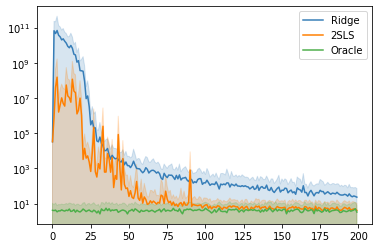

In [25]:
for i in range(len(methods)):
    plt.plot(np.arange(T), mean_online_loss[i], color=colors[i], label=methods[i])
    plt.fill_between(np.arange(T), mean_online_loss[i] - std_online_loss[i], mean_online_loss[i] + std_online_loss[i], color=s_colors[i],alpha=0.2)
plt.yscale('log')
# plt.xlim(-0.,50)
plt.legend()
plt.savefig("IV_online_reg.pdf", format='pdf')

### Istantaneous Regret plots

We can also plot the difference with the ground truth estimator $\left( \left\langle x_t, \beta_t\right\rangle - y_t \right)^2 - \left( \left\langle x_t, \beta \right\rangle - y_t \right)^2
$

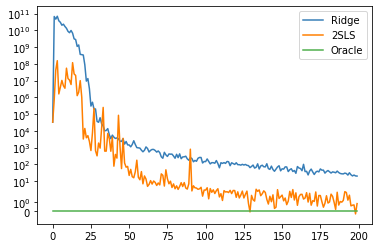

In [26]:
for i in range(len(methods)):
    plt.plot(mean_online_loss[i] - mean_online_loss[-1], color=colors[i], label=methods[i])
    # plt.fill_between(np.arange(T), mean_online_loss[i] - mean_online_loss[-1] - std_online_loss[i], mean_online_loss[i]- mean_online_loss[-1] + std_online_loss[i], color=s_colors[i],alpha=0.2)
plt.yscale('symlog')
# plt.ylim(-10,10)
plt.legend()

### Cumulative Regret plots

The cumulative regret is instead:
$$
    \sum_{s=1}^t \left( \left\langle x_s, \beta_s\right\rangle - y_s \right)^2 - \sum_{s=1}^t \left( \left\langle x_s, \beta \right\rangle - y_s \right)^2
$$

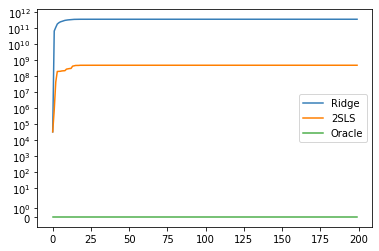

In [27]:
# firt compute cumulative losses for trajectories and the mean and std
cumulative_online_loss = np.cumsum(online_loss, axis=2) 
mean_cumulative_online_loss = np.mean(cumulative_online_loss, axis=0) 
std_cumulative_online_loss = np.std(cumulative_online_loss, axis=0) 

for i in range(len(methods)):
    plt.plot(np.arange(T), mean_cumulative_online_loss[i]-mean_cumulative_online_loss[-1], color=colors[i],label=methods[i])
    # plt.fill_between(np.arange(T), mean_cumulative_online_loss[i] - std_cumulative_online_loss[i], mean_cumulative_online_loss[i] + std_cumulative_online_loss[i], color=s_colors[i],alpha=0.2)   
    
    # plt.plot(np.cumsum(mean_online_loss[i]+mean_scd_terms[i]),color=colors[i],linestyle='dotted')
    # plt.plot(mean_online_loss[i], color=colors[i], label=methods[i])
    # plt.fill_between(np.arange(T), mean_online_loss[i] - std_online_loss[i], mean_online_loss[i] + std_online_loss[i], color=s_colors[i],alpha=0.2)

plt.yscale('symlog')
# plt.xlim(-0.1,50)
plt.legend()
# title = "xps/OnlineRegret_BetaNorm="+str(round(np.linalg.norm(beta_star),2))
# plt.title(title)
# plt.savefig(title+'.pdf',bbox_inches='tight')

### Compute directly offline estimators

In [8]:
theta_star = np.eye(d,d)
beta_star = np.random.multivariate_normal([10],[[1]],d).reshape(-1,)
print("beta = ", beta_star, "\ntheta = ", theta_star)

beta =  [ 9.18444872 10.09678353  9.99760499 10.03248239  9.64812825] 
theta =  [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [9]:
store_betas = np.zeros((len(methods), n_iters, d))

for it in range(n_iters):  # iterations to average the effect of noise
    
    # initialize
    thetas = np.zeros((len(methods),d,d))
    thetas[-1] = theta_star
    betas = np.zeros((len(methods),d))
    betas[-1] = beta_star

    # first stage
    Z = np.random.randn(T,d)
    eps = np.random.randn(T, d)
    # eps = np.zeros((T,d)) 
    X = np.dot(Z, theta_star) + eps
    # second stage
    eta_tilde = np.random.randn(T)
    # noise = eta_tilde + np.linalg.norm(eps, axis=1)  
    noise = eta_tilde + eps[:,0]
    y = np.dot(X, beta_star) + noise

    # z_t, x_t, y_t = Z[t], X[t], y[t]
    # online_loss[it, :, t] = (np.dot(betas, x_t) - y_t)**2        
    betas[0] = np.linalg.inv(X.T @ X) @ X.T @ y
    betas[1] = np.linalg.inv(Z.T @ X) @ Z.T @ y
    store_betas[0, it, :] = betas[0]
    store_betas[1, it, :] = betas[1]

In [10]:
mean_beta_ridge = store_betas[0, :, :].mean(axis=0)
std_beta_ridge = store_betas[0, :, :].std(axis=0)
mean_beta_2SLS = store_betas[1, :, :].mean(axis=0)
std_beta_2SLS = store_betas[1, :, :].std(axis=0)

print("||beta|| = ", round(np.linalg.norm(beta_star),4), "\t\tbeta = ", beta_star)
print("||beta-mean_r|| = ", round(np.linalg.norm(beta_star-mean_beta_ridge),4),  "\tbeta_r = ", betas[0], "\tstd=", std_beta_ridge)
print("||beta-mean_o|| = ", round(np.linalg.norm(beta_star-mean_beta_2SLS),4), "\tbeta_o = ", betas[1], "\tstd=", std_beta_2SLS)
print("L_Z is: ", round(L_Z,4))
print("L_X is: ", round(L_X,4))
print("L_y is: ",round(L_y,4))
print("max |eta_t| is: ", max(abs(noise)))
print(methods)
print(np.sqrt(((betas-beta_star)**2).sum(axis=1)))

||beta|| =  21.9086 		beta =  [ 9.18444872 10.09678353  9.99760499 10.03248239  9.64812825]
||beta-mean_r|| =  0.4993 	beta_r =  [ 9.64863633 10.11107129 10.01039421 10.03055674  9.65074951] 	std= [0.02782653 0.02869948 0.02604052 0.02884278 0.02875037]
||beta-mean_o|| =  0.0122 	beta_o =  [ 9.15109175 10.06507043 10.01972177 10.08101278  9.66602545] 	std= [0.04469197 0.04385438 0.04676343 0.04497231 0.04914854]
L_Z is:  2.0644
L_X is:  3.5262
L_y is:  77.4979
max |eta_t| is:  5.118288855102298
['Ridge', '2SLS', 'Oracle']
[0.4645949  0.07268472 0.        ]


### Graphs

In [28]:
mean_online_loss = np.mean(online_loss, axis=0)
# mean_online_regrets_reg[index_reg] = mean_online_loss[:-1]-mean_online_loss[-1]
std_online_loss = np.std(online_loss[:-1]-online_loss[-1], axis=0)
# std_online_regrets_reg[index_reg] = std_online_loss[:2,:]
# mean_test_loss = np.mean(test_loss, axis=0)
# std_test_loss = np.std(test_loss, axis=0)
# mean_fst_terms = np.mean(fst_terms, axis=0)
# mean_scd_terms = np.mean(scd_terms, axis=0)
# std_fst_terms = np.std(fst_terms, axis=0)
# std_scd_terms = np.std(scd_terms, axis=0)

Text(0.5, 1.0, 'xps/OnlineRegret_BetaNorm=21.91')

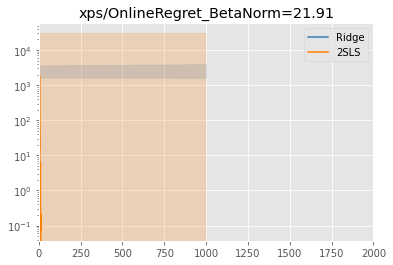

In [33]:
for i in range(len(methods)-1):
    plt.plot(mean_online_loss[i]-mean_online_loss[-1], color=colors[i],label=methods[i])
    plt.fill_between(np.arange(T),np.cumsum(mean_online_loss[i])-np.cumsum(std_online_loss[i]),np.cumsum(mean_online_loss[i])+np.cumsum(std_online_loss[i]), color=s_colors[i],alpha=0.2)   
    # plt.plot(np.cumsum(mean_online_loss[i]+mean_scd_terms[i]),color=colors[i],linestyle='dotted')
    plt.yscale('log')
# plt.xlim(-0.,50)
plt.legend()
title = "xps/OnlineRegret_BetaNorm="+str(round(np.linalg.norm(beta_star),2))
plt.title(title)
# plt.savefig(title+'.pdf',bbox_inches='tight')